# Data Loading and Preprocessing Pipeline Demo

This notebook demonstrates the complete data preprocessing pipeline for shuttle tracking data:
1. Load vehicle locations from database/CSV
2. Convert timestamps to epoch seconds
3. Add closest route information
4. Compute distance deltas
5. Compute speed
6. Segment into consecutive trips
7. Visualize speed over time for a single segment

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import preprocessing functions
from ml.pipelines import segment_pipeline
from ml.data.preprocess import segment_by_consecutive

## Step 1: Load and Preprocess Data

The `preprocess_pipeline()` function runs all preprocessing steps and caches the result.

In [62]:
# Load preprocessed data (uses cache if available)
df = segment_pipeline()

print(f"Loaded {len(df)} location points")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData shape: {df.shape}")

Loading segmented data from /Users/joel/eclipse-workspace/shuttletracker-new/ml/cache/segmented_vehicle_locations.csv
Loaded 1248723 segmented records from cache
Loaded 1248723 location points

Columns: ['vehicle_id', 'latitude', 'longitude', 'timestamp', 'epoch_seconds', 'dist_to_route', 'route', 'closest_lat', 'closest_lon', 'polyline_idx', 'segment_id', 'distance_km', 'speed_kmh']

Data shape: (1248723, 13)


In [63]:
# Display first few rows
df.head(20)

,vehicle_id,latitude,longitude,timestamp,epoch_seconds,dist_to_route,route,closest_lat,closest_lon,polyline_idx,segment_id,distance_km,speed_kmh
0,212014918466445,42.730867,-73.677149,2025-08-23 18:23:16.052,2.028380e+07,0.003092,NORTH,42.730877,-73.677184,7,3,NaN,NaN
1,212014918466445,42.730865,-73.677149,2025-08-23 18:23:23.566,2.028380e+07,0.003110,NORTH,42.730875,-73.677185,7,3,0.000202,0.097003
2,212014918466445,42.730785,-73.677153,2025-08-23 18:23:36.056,2.028382e+07,0.001769,WEST,42.730769,-73.677155,0,3,0.012032,3.467955
3,212014918466445,42.730692,-73.676854,2025-08-23 18:24:41.041,2.028388e+07,0.003299,WEST,42.730722,-73.676849,7,7,NaN,NaN
4,212014918466445,42.730716,-73.676687,2025-08-23 18:24:47.294,2.028389e+07,0.001530,WEST,42.730702,-73.676689,0,7,0.013251,7.628869
5,212014918466445,42.730663,-73.676464,2025-08-23 18:24:54.251,2.028389e+07,0.001283,WEST,42.730652,-73.676467,7,7,0.019010,9.837122
6,212014918466445,42.730524,-73.676165,2025-08-23 18:31:40.023,2.028430e+07,0.000657,NORTH,42.730529,-73.676162,0,10,NaN,NaN
7,212014918466445,42.730437,-73.675972,2025-08-23 18:31:53.021,2.028431e+07,0.001114,NORTH,42.730427,-73.675977,0,10,0.018909,5.237206
8,212014918466445,42.730320,-73.675634,2025-08-23 18:32:03.063,2.028432e+07,0.002371,NORTH,42.730300,-73.675642,0,10,0.030876,11.068736
9,212014918466445,42.731323,-73.672000,2025-08-23 18:34:58.014,2.028450e+07,0.003695,NORTH,42.731356,-73.672011,0,30,NaN,NaN


In [64]:
# Display rows surrounding largest speed
max_speed_idx = df['speed_kmh'].idxmax()
start_idx = max(0, max_speed_idx - 5)
end_idx = min(len(df), max_speed_idx + 6)
df.iloc[start_idx:end_idx]

,vehicle_id,latitude,longitude,timestamp,epoch_seconds,dist_to_route,route,closest_lat,closest_lon,polyline_idx,segment_id,distance_km,speed_kmh
370620,281474978656308,42.732379,-73.671353,2025-10-10 20:09:01.034,2.443734e+07,0.001941,NORTH,42.732362,-73.671355,7,169471,2.960936e-02,21.564575
370621,281474978656308,42.732405,-73.671480,2025-10-10 20:09:10.164,2.443735e+07,0.002936,NORTH,42.732379,-73.671484,7,169471,1.068788e-02,4.214280
370622,281474978656308,42.732404,-73.671482,2025-10-10 20:09:22.084,2.443736e+07,0.002723,NORTH,42.732379,-73.671486,7,169471,1.280237e-04,0.038665
370623,281474978656308,42.732557,-73.672593,2025-10-10 20:09:32.034,2.443737e+07,0.003921,NORTH,42.732521,-73.672598,7,169471,9.219288e-02,33.356220
370624,281474978656308,42.732704,-73.673691,2025-10-10 20:09:39.594,2.443738e+07,0.000096,NORTH,42.732703,-73.673691,7,169471,9.153406e-02,43.587650
370625,281474978656308,42.732848,-73.674804,2025-10-10 20:09:43.982,2.443738e+07,0.000089,NORTH,42.732847,-73.674804,7,169471,9.236239e-02,75.775889
370626,281474978656308,42.732957,-73.675540,2025-10-10 20:09:48.987,2.443739e+07,0.001503,NORTH,42.732943,-73.675542,7,169471,6.116385e-02,43.993977
370627,281474978656308,42.730694,-73.676754,2025-10-10 20:19:49.943,2.443799e+07,0.001440,WEST,42.730707,-73.676752,7,169482,NaN,NaN
370628,281474978656308,42.730694,-73.676754,2025-10-10 20:19:58.572,2.443800e+07,0.001440,WEST,42.730707,-73.676752,7,169482,8.152287e-07,0.000340
370629,281474978656308,42.730682,-73.676405,2025-10-10 20:20:10.021,2.443801e+07,0.004990,WEST,42.730638,-73.676418,7,169482,2.837479e-02,8.922110


## Step 2: Basic Data Summary

In [65]:
# Summary statistics
print("Summary Statistics:")
print("="*60)
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Number of vehicles: {df['vehicle_id'].nunique()}")

# Handle NaN values in route column
route_values = df['route'].dropna().unique()
print(f"Number of routes: {len(route_values)}")
print(f"\nRoutes: {sorted(route_values)}")

# Count NaN routes
nan_routes = df['route'].isna().sum()
print(f"Unmatched locations (no route): {nan_routes} ({nan_routes/len(df)*100:.2f}%)")

print(f"\nSpeed statistics (km/h):")
print(df['speed_kmh'].describe())

Summary Statistics:
Date range: 2025-07-31 15:55:27.052000 to 2025-12-24 14:29:59
Number of vehicles: 27
Number of routes: 2

Routes: ['NORTH', 'WEST']
Unmatched locations (no route): 0 (0.00%)

Speed statistics (km/h):
count    1.113355e+06
mean     2.147433e+01
std      1.440359e+01
min      0.000000e+00
25%      8.739511e+00
50%      2.187892e+01
75%      3.325694e+01
max      7.577589e+01
Name: speed_kmh, dtype: float64


## Step 3: Segment into Consecutive Trips

Segments are created based on:
- Vehicle ID changes
- Time gaps > max_timedelta seconds

In [66]:
# Segment the data with 5-minute maximum time gap
max_timedelta = 15
segmented_df = segment_by_consecutive(df, max_timedelta=max_timedelta, segment_column='segment_id')

num_segments = segmented_df['segment_id'].nunique()
print(f"Created {num_segments} segments with max time gap of {max_timedelta}s ({max_timedelta/60:.1f} minutes)")

# Segment size distribution
segment_sizes = segmented_df.groupby('segment_id').size()
print(f"\nSegment size statistics:")
print(segment_sizes.describe())

Created 118899 segments with max time gap of 15s (0.2 minutes)

Segment size statistics:
count    118899.000000
mean         10.502384
std           8.709124
min           3.000000
25%           5.000000
50%           8.000000
75%          13.000000
max          99.000000
dtype: float64


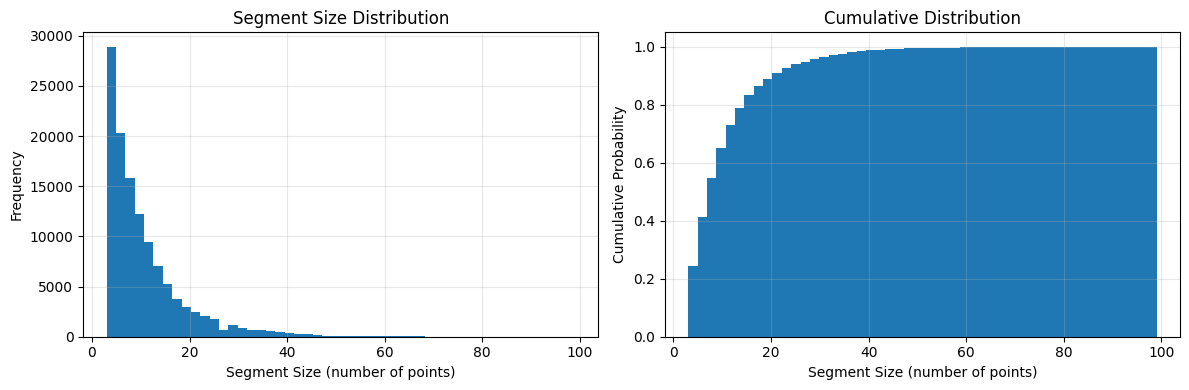


Segments with >= 10 points: 47457 (39.9%)
Segments with >= 20 points: 14514 (12.2%)
Segments with >= 50 points: 656 (0.6%)


In [67]:
# Plot segment size distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
segment_sizes.hist(bins=50)
plt.xlabel('Segment Size (number of points)')
plt.ylabel('Frequency')
plt.title('Segment Size Distribution')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
segment_sizes.hist(bins=50, cumulative=True, density=True)
plt.xlabel('Segment Size (number of points)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSegments with >= 10 points: {(segment_sizes >= 10).sum()} ({(segment_sizes >= 10).sum() / len(segment_sizes) * 100:.1f}%)")
print(f"Segments with >= 20 points: {(segment_sizes >= 20).sum()} ({(segment_sizes >= 20).sum() / len(segment_sizes) * 100:.1f}%)")
print(f"Segments with >= 50 points: {(segment_sizes >= 50).sum()} ({(segment_sizes >= 50).sum() / len(segment_sizes) * 100:.1f}%)")

## Step 4: Select and Visualize One Segment

Let's select a segment with a reasonable number of points and visualize its speed over time.

In [68]:
# Filter to segments with valid routes (no NaN)
segmented_with_routes = segmented_df[segmented_df['route'].notna()].copy()
valid_segment_sizes = segmented_with_routes.groupby('segment_id').size()

# Find segments with at least 20 points for better visualization
large_segments = valid_segment_sizes[valid_segment_sizes >= 20].index

if len(large_segments) == 0:
    print("No segments with >= 20 points and valid routes found. Using largest valid segment.")
    selected_segment_id = valid_segment_sizes.idxmax()
else:
    # Select a segment from the middle of the dataset
    selected_segment_id = large_segments[len(large_segments) // 2]

# Extract the selected segment
segment = segmented_with_routes[segmented_with_routes['segment_id'] == selected_segment_id].copy()
segment = segment.sort_values('timestamp').reset_index(drop=True)

print(f"Selected segment {selected_segment_id}")
print(f"Number of points: {len(segment)}")
print(f"Vehicle ID: {segment['vehicle_id'].iloc[0]}")
print(f"Route: {segment['route'].iloc[0]}")
print(f"Time range: {segment['timestamp'].iloc[0]} to {segment['timestamp'].iloc[-1]}")
print(f"Duration: {(segment['timestamp'].iloc[-1] - segment['timestamp'].iloc[0]).total_seconds() / 60:.1f} minutes")

Selected segment 47091
Number of points: 25
Vehicle ID: 281474979465689
Route: WEST
Time range: 2025-11-19 13:07:10.028000 to 2025-11-19 13:10:02.014000
Duration: 2.9 minutes


In [69]:
# Display segment data
segment[['vehicle_id', 'timestamp', 'latitude', 'longitude', 'route', 'distance_km', 'speed_kmh', 'epoch_seconds']].head(10)

,vehicle_id,timestamp,latitude,longitude,route,distance_km,speed_kmh,epoch_seconds
0,281474979465689,2025-11-19 13:07:10.028,42.728038,-73.687202,WEST,NaN,NaN,2.786803e+07
1,281474979465689,2025-11-19 13:07:21.004,42.728520,-73.687063,WEST,0.055087,18.067940,2.786804e+07
2,281474979465689,2025-11-19 13:07:26.045,42.729012,-73.686915,WEST,0.056365,40.252567,2.786805e+07
3,281474979465689,2025-11-19 13:07:31.022,42.729445,-73.686843,WEST,0.048211,34.872103,2.786805e+07
4,281474979465689,2025-11-19 13:07:37.076,42.729766,-73.686750,WEST,0.036681,21.812541,2.786806e+07
5,281474979465689,2025-11-19 13:07:42.060,42.730130,-73.686679,WEST,0.040771,29.449256,2.786806e+07
6,281474979465689,2025-11-19 13:07:48.076,42.730593,-73.686575,WEST,0.052173,31.220753,2.786807e+07
7,281474979465689,2025-11-19 13:07:54.031,42.730837,-73.686478,WEST,0.028470,17.211359,2.786807e+07
8,281474979465689,2025-11-19 13:08:00.015,42.730862,-73.686471,WEST,0.001431,0.860603,2.786808e+07
9,281474979465689,2025-11-19 13:08:08.003,42.730855,-73.686473,WEST,0.000000,0.000000,2.786809e+07


## Step 5: Visualize Speed Over Time

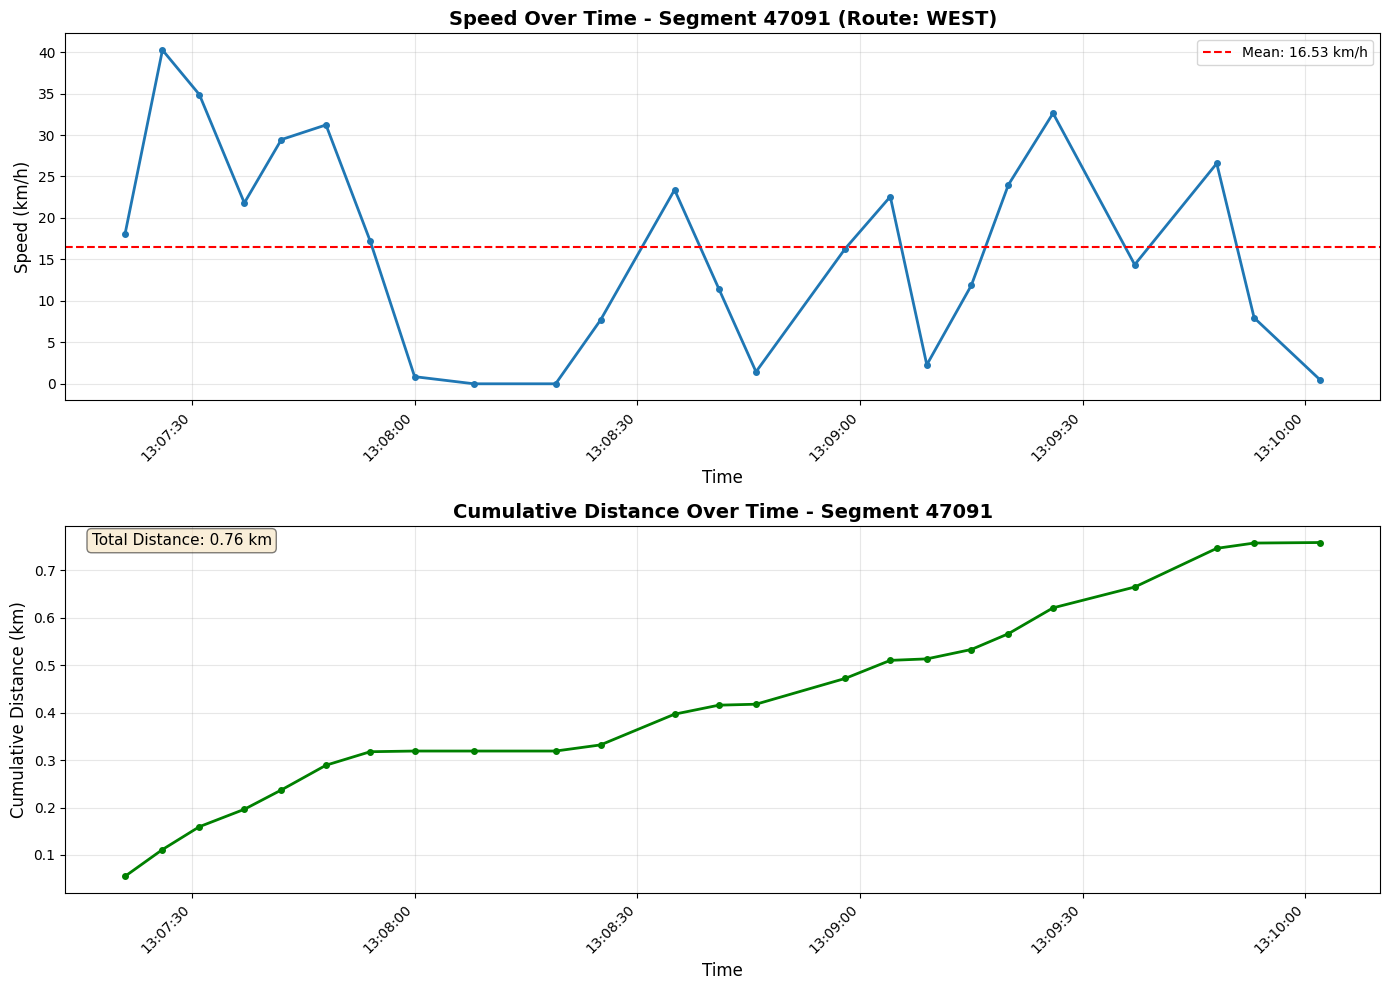


Speed Statistics for Segment 47091:
  Mean speed: 16.53 km/h
  Median speed: 16.75 km/h
  Max speed: 40.25 km/h
  Min speed: 0.00 km/h
  Std dev: 12.33 km/h
  Total distance: 0.76 km


In [70]:
# Create time-based plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Filter out NaN values for plotting
segment_clean = segment[segment['speed_kmh'].notna()].copy()

# Plot 1: Speed over time
ax1 = axes[0]
ax1.plot(segment_clean['timestamp'], segment_clean['speed_kmh'], marker='o', linestyle='-', linewidth=2, markersize=4)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Speed (km/h)', fontsize=12)
ax1.set_title(f'Speed Over Time - Segment {selected_segment_id} (Route: {segment["route"].iloc[0]})', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
mean_speed = segment_clean['speed_kmh'].mean()
ax1.axhline(y=mean_speed, color='r', linestyle='--', label=f'Mean: {mean_speed:.2f} km/h')
ax1.legend()

# Rotate x-axis labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Distance traveled over time (cumulative)
ax2 = axes[1]
cumulative_distance = segment_clean['distance_km'].cumsum()
ax2.plot(segment_clean['timestamp'], cumulative_distance, marker='o', linestyle='-', linewidth=2, markersize=4, color='green')
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Cumulative Distance (km)', fontsize=12)
ax2.set_title(f'Cumulative Distance Over Time - Segment {selected_segment_id}', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
total_distance = cumulative_distance.iloc[-1]
ax2.text(0.02, 0.98, f'Total Distance: {total_distance:.2f} km',
         transform=ax2.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Rotate x-axis labels
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"\nSpeed Statistics for Segment {selected_segment_id}:")
print(f"  Mean speed: {segment_clean['speed_kmh'].mean():.2f} km/h")
print(f"  Median speed: {segment_clean['speed_kmh'].median():.2f} km/h")
print(f"  Max speed: {segment_clean['speed_kmh'].max():.2f} km/h")
print(f"  Min speed: {segment_clean['speed_kmh'].min():.2f} km/h")
print(f"  Std dev: {segment_clean['speed_kmh'].std():.2f} km/h")
print(f"  Total distance: {total_distance:.2f} km")

## Step 6: Additional Visualization - Speed Distribution

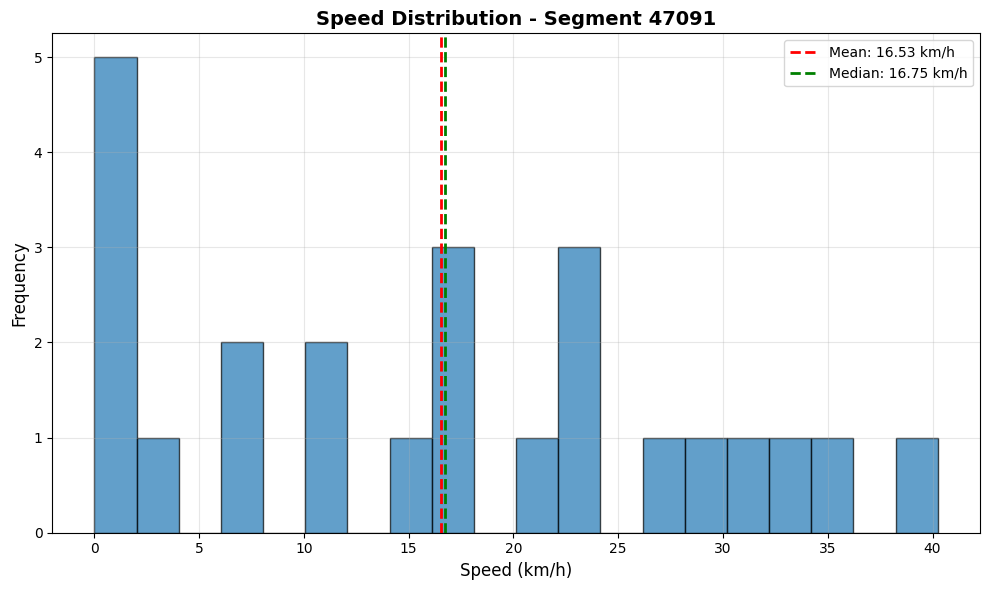

In [71]:
# Speed distribution histogram (using clean data without NaN)
segment_clean = segment[segment['speed_kmh'].notna()].copy()

plt.figure(figsize=(10, 6))
plt.hist(segment_clean['speed_kmh'], bins=20, edgecolor='black', alpha=0.7)
mean_speed = segment_clean['speed_kmh'].mean()
median_speed = segment_clean['speed_kmh'].median()
plt.axvline(mean_speed, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_speed:.2f} km/h')
plt.axvline(median_speed, color='g', linestyle='--', linewidth=2, label=f'Median: {median_speed:.2f} km/h')
plt.xlabel('Speed (km/h)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Speed Distribution - Segment {selected_segment_id}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Step 7: Geographic Visualization (Optional)

Plot the segment path on a simple coordinate plot.

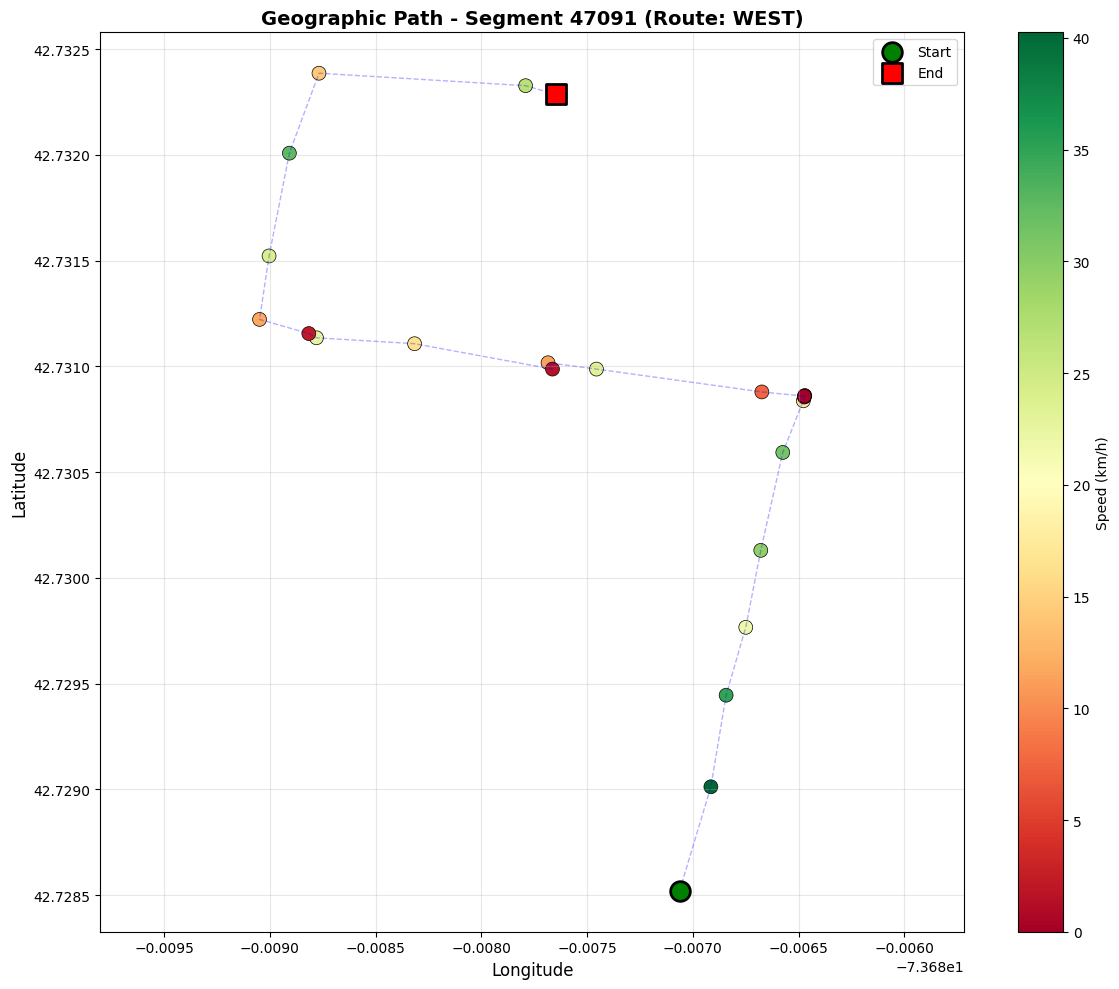

In [72]:
# Plot the geographic path with speed as color (using clean data without NaN)
segment_clean = segment[segment['speed_kmh'].notna()].copy()

plt.figure(figsize=(12, 10))

# Create a scatter plot with speed as color
scatter = plt.scatter(segment_clean['longitude'], segment_clean['latitude'],
                     c=segment_clean['speed_kmh'], cmap='RdYlGn',
                     s=100, edgecolors='black', linewidth=0.5)

# Add line connecting the points
plt.plot(segment_clean['longitude'], segment_clean['latitude'],
         color='blue', alpha=0.3, linewidth=1, linestyle='--')

# Mark start and end
plt.scatter(segment_clean['longitude'].iloc[0], segment_clean['latitude'].iloc[0],
           color='green', s=200, marker='o', edgecolors='black', linewidth=2, label='Start', zorder=5)
plt.scatter(segment_clean['longitude'].iloc[-1], segment_clean['latitude'].iloc[-1],
           color='red', s=200, marker='s', edgecolors='black', linewidth=2, label='End', zorder=5)

plt.colorbar(scatter, label='Speed (km/h)')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title(f'Geographic Path - Segment {selected_segment_id} (Route: {segment["route"].iloc[0]})',
         fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:
1. ✓ Loading preprocessed vehicle location data
2. ✓ Segmenting data into consecutive trips
3. ✓ Visualizing speed over time for a single segment
4. ✓ Analyzing speed distribution and geographic path

The preprocessing pipeline handles:
- Timestamp conversion to epoch seconds
- Route matching using closest point algorithm
- Distance calculation between consecutive points
- Speed calculation from distance and time
- Segmentation based on vehicle ID and time gaps

All preprocessing results are cached for efficient repeated use.